In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install transformers

## Importing the necessary libraries

In [157]:
import numpy as np
import pandas as pd
from collections import Counter
import nltk
import torch
import random
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from transformers import AdamW

# Make sure to download the Punkt tokenizer models
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/rajarshi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Choose the language and visualize the data

In [325]:
l = "eng"
train_data = pd.read_csv("split/{}/train_{}.csv".format(l,l))
val_data = pd.read_csv("split/{}/val_{}.csv".format(l,l))
print(train_data.shape)
print(val_data.shape)
train_data.head(10)

(4400, 3)
(1100, 3)


,Score,sentence1,sentence2
0,0.25,"@HillaryClinton Did your rich Saudi donors, wh...",@SCOTUS_Scalia Right. Words no longer have mea...
1,0.69,No consensus exists as to when the French Revo...,Napoleonic Wars The Napoleonic Wars are wars t...
2,0.16,Three greyhounds racing on a track,Three people sitting down at a small table.
3,0.28,i loved that both the lead male and female wer...,I can't remember if I read Darkfever first or ...
4,0.59,In this book Percy Jackson is telling the tale...,I was never a fan of Percy Jackson because of ...
5,0.44,BRAVO TO BOTH OF YOU BEAUTIFULLY EXPLAINED HOL...,Today I am grateful for the #reproductiveright...
6,0.91,But the prime minister told the BBC he wasn't ...,He said he wasn't bothered by polls and that h...
7,0.97,I had a big breakthrough on that skirt I was w...,I've made some progress with the skirt I'm wor...
8,0.41,It will also be used for driver and maintenanc...,Country Energy also is represented by a traini...
9,0.38,The Accidental Vampire is just as fun as the o...,Also Elvi was a fun character with her single ...


This cell essentially tokenizes the sentences corresponding to that language to create a new vocab which is used for the extension of the exsiting pretrained vocab of the BERT tokenizer 

In [326]:
all_sentences = pd.concat([train_data['sentence1'], train_data['sentence2']]).tolist()
all_text = " ".join(all_sentences)
# print(all_text)
tokens = nltk.word_tokenize(all_text)
freq_dist = Counter(tokens)
vocab = sorted(freq_dist, key=freq_dist.get, reverse=True)
print(vocab[:100]) 

['.', 'the', ',', 'a', 'of', 'and', 'to', 'is', 'in', 'I', '#', '@', "'s", 'on', 'A', 'for', '!', 'with', 'that', 'you', 'The', 'it', 'was', 'are', '?', 'this', "n't", 'her', 'as', 'be', 'not', 'have', 'an', 'at', 'by', 'man', 'from', 'he', 'my', 'but', 'It', 'like', 'his', 'do', '``', 'book', 'or', 'one', 'about', 'can', 'out', 'has', 'me', 'what', 'she', 'all', 'up', ':', 'realDonaldTrump', 'your', 'their', 'more', 'will', 'people', 'woman', 'so', 'they', "''", 'who', 'just', 'This', 'You', '...', 'there', 'him', 'were', 'if', 'would', 'get', 'other', 'did', 'women', 'had', 'He', '&', 'into', 'series', 'know', 'In', 'no', 'love', 'first', 'we', 'two', 'over', 'also', 'some', 'read', 'HillaryClinton', "'m"]


In [327]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
m = BertModel.from_pretrained('bert-base-multilingual-cased')
tokenizer.add_tokens(vocab)
# Resize the embeddings to account for the new tokens
m.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 127747. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(127747, 768)

In [328]:
print(len(tokenizer))

127747


### Custom Pytorch dataset for generation of input tokens, attention masks, token ids and encodings

In [330]:
class CustomDataset(Dataset):
    def __init__(self, tokenizer, sentences1, sentences2, scores):
        self.tokenizer = tokenizer
        self.sentences1 = sentences1
        self.sentences2 = sentences2
        self.scores = scores

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        encodings = self.tokenizer(self.sentences1[idx], self.sentences2[idx], 
                                   truncation=True, padding='max_length', max_length=512, return_tensors='pt')
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'token_type_ids': encodings['token_type_ids'].flatten(),
            'labels': torch.tensor(self.scores[idx], dtype=torch.float)
        }

### Implementation of the Multilingual bert based model for calculation of the Semantic Relatedness Score

In [331]:
class STRModel(torch.nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model
        self.dropout = torch.nn.Dropout(0.1)
        self.regressor = nn.Sequential(
            nn.Linear(bert_model.config.hidden_size, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, input_ids, attention_mask):
        # Get the pooled output from the BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        return self.regressor(pooled_output).squeeze(-1)

model = STRModel(m)

In [332]:
train_dataset = CustomDataset(tokenizer, train_data['sentence1'], train_data['sentence2'], train_data['Score'])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
val_dataset = CustomDataset(tokenizer, val_data['sentence1'], val_data['sentence2'], val_data['Score'])
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

### Initializing the training params

In [333]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00002, eps=1e-8, weight_decay = 0.01)
total_steps = len(train_loader) * 5  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.MSELoss()
num_epochs = 6

In [334]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_value = 42
set_seed(seed_value)
eng_train_losses, eng_val_losses = [],[]
model.zero_grad()  
accumulation_steps = 1

for epoch in range(num_epochs):
    model.train()
    # train_loss = 0
    accumulation_loss = 0

    for step, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        predictions = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(predictions, labels) / accumulation_steps
        accumulation_loss += loss.item()
        loss.backward()
        if (step + 1) % accumulation_steps == 0:
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 2.5)
            optimizer.step()
            scheduler.step()
            model.zero_grad()
            
    avg_train_loss = accumulation_loss / len(train_loader)
    eng_train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0
    predictions, actuals = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(output, labels)
            val_loss += loss.item()
            predictions.extend(output.detach().cpu().numpy())
            actuals.extend(labels.detach().cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    eng_val_losses.append(avg_val_loss)
    val_correlation, _ = pearsonr(predictions, actuals)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Correlation: {val_correlation:.4f}')

Epoch 1/6, Training Loss: 0.0837, Validation Loss: 0.1991, Validation Correlation: 0.6392
Epoch 2/6, Training Loss: 0.0490, Validation Loss: 0.1851, Validation Correlation: 0.6994
Epoch 3/6, Training Loss: 0.0395, Validation Loss: 0.1798, Validation Correlation: 0.7363


KeyboardInterrupt: 

In [276]:
from scipy.stats import pearsonr

actuals = []
predictions = []

model.eval() 
with torch.no_grad():  
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions.extend(output.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

correlation, _ = pearsonr(predictions, actuals)
print(f'Rank correlation coefficient for validation set: {correlation:.4f}')

Rank correlation coefficient for validation set: 0.2348


In [266]:
def preprocess_test(l, path):
    ids = []
    test_data = pd.read_csv(path)
    cell_value_test = test_data.iloc[0, data.columns.get_loc('Text')]
    print(repr(cell_value_test))
    split_text2 = test_data["Text"].str.split("\r\n", expand=True)  
    # print(split_text2)
    test_data["sentence1"] = split_text2[0]
    test_data["sentence2"] = split_text2[1]
    ids = test_data['PairID'].to_list()
    test_data.drop(["PairID", "Text"], axis=1, inplace=True)
    test_data.to_csv(f'test_{l}.csv', index = False)
    return test_data, ids

test_path = "./langs/{}/{}_dev.csv".format(l,l)
test_data, ids = preprocess_test(l, test_path)
test_data.head(10)

'"రాజన్నసిరిసిల్ల జిల్లాలో మాట్లాడిన తెరాస నేత కేటీఆర్ కెసిఆర్ లాంటి నాయకుడు చావు నోట్లో తలపెట్టీ మన కోసం తెలంగాణ తెచ్చాడన్నారు ."\r\n"తెరాస నేత కేటిఅర్ రాజన్న సిరిసిల్ల జిల్లాలో మాట్లాడుతూ కేసిఆర్ చాలా కష్టాలతో పోరాడి తెలంగాణ ని తీసుకువచ్చారని చెప్పారు."'


,sentence1,sentence2
0,"""రాజన్నసిరిసిల్ల జిల్లాలో మాట్లాడిన తెరాస నేత ...","""తెరాస నేత కేటిఅర్ రాజన్న సిరిసిల్ల జిల్లాలో మ..."
1,"""డ్రగ్స్ కేసులో ఇప్పటి వరకు విచారణ ఎదుర్కొన్న ...","""ఇప్పటి వరకు డ్రగ్స్ కేసులో విచారణ ఎదుర్కొంటున..."
2,"""మోడీ యాప్ ద్వారా ఒలింపిక్స్పై ఎందరో స్పందించా...","""మోదీ యాప్ ద్వారా ఒలింపిక్స్పై చాలా మంది స్పంద..."
3,"""ఈ పిటిషన్ మంగళవారం జస్టిస్ ఎన్వీ రమణ నేతృత్వం...","""సాక్షాత్తు అమ్మవారి పేరుమీద జరుగుతున్న ఈ వ్యవ..."
4,"""నేషనల్ హెరాల్డ్ కేసులో ఢిల్లీ హైకోర్టు కీలక న...","""ఢిల్లీ హైకోర్టు నేషనల్ హెరాల్డ్ కేసులో ఊహకందన..."
5,"""బాలీవుడ్ నటి ఆలియా భట్ తన పార్టీ గుర్తును ప్ర...","""హిందీ నటి అలియా భట్ పార్టీ గుర్తును ప్రకటించి..."
6,"""ఈ సినిమా ఈ ఏడాది ద్వితీయార్థంలో ప్రేక్షకుల ము...",""". హిస్టారికల్ ఎలిమెంట్స్తో తెరకెక్కుతున్న ఈ స..."
7,"""బోరుబావిలో మరో చిన్నారి పడింది .""","""బోరుబావిలో పడిపోయిన మరో చిన్నారి ."""
8,"""నత్తి నా కొ*** అంటూ నాని ఫై శ్రీ రెడ్డి దారుణ...","""సినీ హీరో నాని ఫై వివాదస్పద నటి శ్రీ రెడ్డి ద..."
9,"""టిం ఇండియా ఓపెనర్ ధావన్కు గాయం కావడంతో అతని స...","""కోడిరామకృష్ణను కడసారి చూసేందుకు అభిమానులు ప్ర..."


In [267]:
class CustomTestDataset(Dataset):
    def __init__(self, tokenizer, sentences1, sentences2):
        self.tokenizer = tokenizer
        self.sentences1 = sentences1
        self.sentences2 = sentences2

    def __len__(self):
        # return len(self.scores)
        return len(self.sentences1)

    def __getitem__(self, idx):
        encodings = self.tokenizer(self.sentences1[idx], self.sentences2[idx], 
                                   truncation=True, padding='max_length', max_length=512, return_tensors='pt')
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'token_type_ids': encodings['token_type_ids'].flatten()
        }
test_dataset = CustomTestDataset(tokenizer, test_data['sentence1'], test_data['sentence2'])
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [270]:
test_preds = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pred = model(input_ids = input_ids, attention_mask = attention_mask)
        test_preds.extend(pred.detach().cpu().numpy())

test_preds

[0.07608747,
 0.40040776,
 0.3475537,
 0.025146337,
 0.096882306,
 0.30697113,
 0.021229548,
 0.48214075,
 0.21925864,
 0.00667518,
 0.077314004,
 -0.007843008,
 -0.016589718,
 0.00043690205,
 0.20367773,
 0.31839344,
 0.09576125,
 0.2855913,
 0.050818123,
 0.09783805,
 0.0044587124,
 0.29999423,
 0.5634832,
 0.10903929,
 0.38014045,
 0.02316415,
 0.038261417,
 0.12636901,
 0.21609953,
 0.0927302,
 0.41535982,
 0.031273004,
 0.05496765,
 0.32071486,
 -0.024837488,
 0.22196388,
 0.13419577,
 0.044988602,
 0.07945691,
 0.091460474,
 0.003133757,
 0.020275349,
 0.07024598,
 0.17382115,
 0.007998986,
 -0.03916105,
 0.02234858,
 0.27633741,
 0.05671069,
 0.12110586,
 0.17343009,
 0.22308856,
 -0.0014804769,
 0.06294429,
 0.26798108,
 0.4276882,
 0.09275094,
 0.037228417,
 -0.020930478,
 0.0431194,
 0.039670065,
 0.01256022,
 0.060593583,
 0.15902004,
 0.26947647,
 0.025605792,
 0.04591001,
 0.124770336,
 0.14910796,
 0.031166697,
 -0.040921636,
 -0.0146730635,
 -0.03176841,
 0.043312803,
 0

In [273]:
results = pd.DataFrame({'PairID' : ids, 'Pred_Score' : test_preds})
results.to_csv("results_{}.csv".format(l))

In [299]:
amh_train_losses
amh_val_losses

[0.054502435773611066,
 0.1416378079354763,
 0.057175772562623024,
 0.10302871398627758,
 0.1279990044236183,
 0.12200306847691536]

In [289]:
esp_train_losses
esp_val_losses

[0.13847111891477537,
 0.10451075893182021,
 0.11478948077330223,
 0.1293855103162619,
 0.13295587916404772,
 0.13368273774782816]

In [275]:
train_losses
val_losses

mar_train_losses
mar_val_losses

[0.03311300259799911,
 0.030259316994084254,
 0.02618156337680725,
 0.023139799698295757,
 0.028758294004787747,
 0.03932390717041288,
 0.040416133804963186,
 0.038676330369984746,
 0.040571573675952405,
 0.03833422210449592,
 0.04035561282633462,
 0.03966020661382339,
 0.04163965552599511,
 0.03907451402539244,
 0.041504902387053795,
 0.0378759587661196,
 0.038921332464386255,
 0.04023447232400505,
 0.03748979145645076,
 0.03824917596772823]

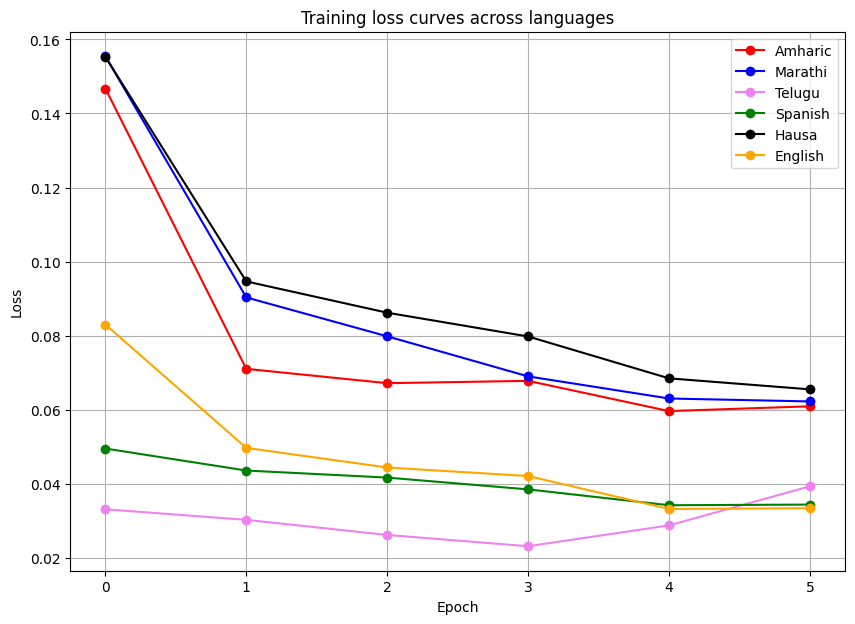

In [338]:

plt.figure(figsize = (10,7))
plt.plot(range(6), amh_train_losses, color = 'red',marker ='o')
plt.plot(range(6), mar_train_losses, color = 'blue',marker ='o')
plt.plot(range(6), train_losses[:6], color = 'violet',marker ='o')
plt.plot(range(6), esp_train_losses, color='green',marker ='o')
plt.plot(range(6), hau_train_losses, color='black',marker ='o')
plt.plot(range(6), [0.0830, 0.0497, 0.0444, 0.0421, 0.0332, 0.0334], color='orange', marker ='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training loss curves across languages")
# Showing the legend
plt.legend(["Amharic", "Marathi","Telugu","Spanish", "Hausa", "English"])
plt.grid()
plt.savefig('tplot.png')
plt.show()

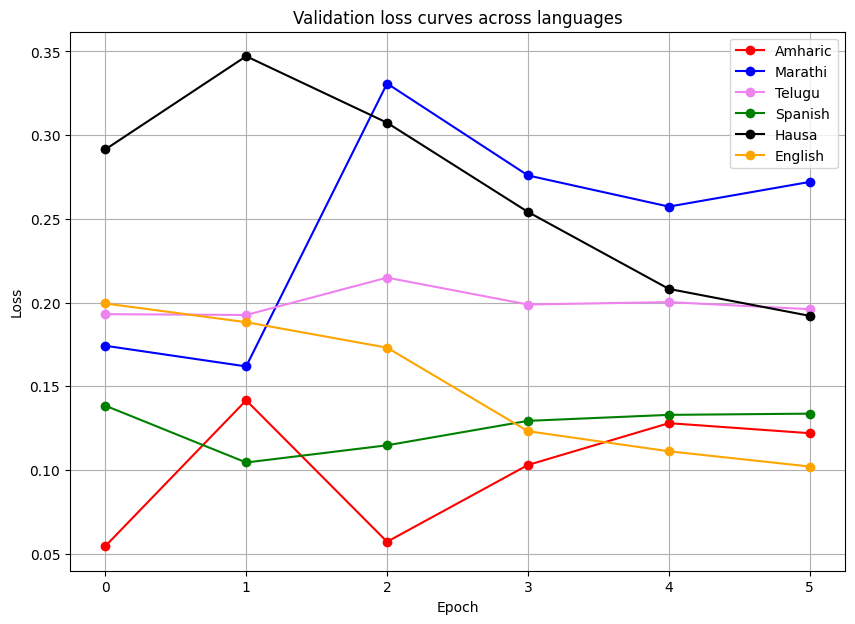

In [337]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
plt.plot(range(6), amh_val_losses, color = 'red',marker ='o')
plt.plot(range(6), mar_val_losses, color = 'blue',marker ='o')
plt.plot(range(6), val_losses[:6], color = 'violet',marker ='o')
plt.plot(range(6), esp_val_losses, color='green',marker ='o')
plt.plot(range(6), hau_val_losses, color='black',marker ='o')
plt.plot(range(6), [0.1995, 0.1883, 0.1731, 0.1232, 0.1112, 0.1021], color='orange', marker ='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Validation loss curves across languages")
# Showing the legend
plt.legend(["Amharic", "Marathi","Telugu","Spanish", "Hausa", "English"])
plt.grid()
plt.savefig('vplot.png')
plt.show()
